/home/shaoyuan/Documents/Software/pypolycontain/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/shaoyuan/Documents/Software/pypolycontain/pypolycontain/containment.py:16: UserWarning: You don't have CDD package installed. Unable to run cone ray generation.
  warnings.warn("You don't have CDD package installed. Unable to run cone ray generation.")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-05


100%|██████████| 12/12 [00:00<00:00, 100865.03it/s]


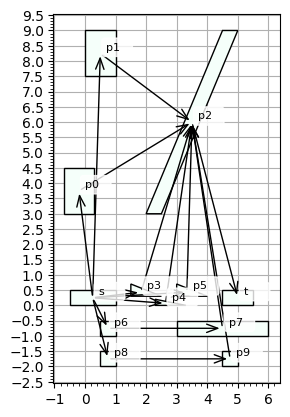

In [1]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np

from large_gcs.graph.cost_constraint_factory import (
    create_2d_x_equality_edge_constraint,
    create_2d_y_equality_edge_constraint,
    create_l1norm_edge_cost,
)
from large_gcs.graph.graph import DefaultGraphCostsConstraints, Edge, Graph

from large_gcs.algorithms.search_algorithm import SearchNode
from pydrake.all import HPolyhedron, VPolytope
from large_gcs.domination_checkers.ah_containment_domination_checker import (
    AHContainmentDominationChecker,
)

# import logging
# logging.basicConfig(level=logging.INFO)

def create_polyhedral_hor_vert_b_graph() -> Graph:
    dim = 2
    # Convex sets
    box_vert = np.array([[0, 0], [1, 0], [1, 1.5], [0, 1.5]], dtype=np.float64)
    sets = (
        # source
        Polyhedron.from_vertices([[-0.5, 0], [1, 0], [1, 0.5], [-0.5, 0.5]]),
        # target
        Polyhedron.from_vertices([[4.5, 0], [5.5, 0], [5.5, 0.5], [4.5, 0.5]]),
        # intermediate sets
        Polyhedron.from_vertices(box_vert + np.array([-0.7, 3])),
        Polyhedron.from_vertices(box_vert + np.array([0, 7.5])),
        # Diagonal set
        Polyhedron.from_vertices([[2, 3], [2.5, 3], [5, 9], [4.5, 9]]),
        # Cluster of 3
        Polyhedron.from_vertices([[1.5, 0.3], [2.5, 0.3], [1.5, 0.7]]),
        Polyhedron.from_vertices([[2.3, 0], [3.3, 0], [2.3, 0.2]]),
        Polyhedron.from_vertices([[3, 0.3], [4, 0.3], [3, 0.7]]),
        # 2nd row from the bottom
        Polyhedron.from_vertices([[0.5, -1], [1, -1], [1, -0.5], [0.5, -0.5]]),
        Polyhedron.from_vertices([[3, -1], [6, -1], [6, -0.5], [3, -0.5]]),
        # bottommost row
        Polyhedron.from_vertices([[0.5, -2], [1, -2], [1, -1.5], [0.5, -1.5]]),
        Polyhedron.from_vertices([[4.5, -2], [5, -2], [5, -1.5], [4.5, -1.5]]),
    )

    # Vertex names
    vertex_names = ["s", "t"]
    vertex_names += [f"p{i}" for i in range(len(sets) - 2)]

    # Edge costs
    # edge_cost = create_l2norm_squared_edge_cost(dim)
    edge_cost = create_l1norm_edge_cost(dim)
    default_costs_constraints = DefaultGraphCostsConstraints(edge_costs=[edge_cost])
    # Add convex sets to graph
    G = Graph(default_costs_constraints)
    G.add_vertices_from_sets(sets, names=vertex_names)
    G.set_source("s")
    G.set_target("t")

    # Edges
    vert_edges = {
        "s": ("p0", "p1", "p6", "p8"),
        "p2": ("t",),
        "p3": ("p2",),
        "p4": ("p2",),
        "p5": ("p2",),
        "p7": ("p2",),
        "p9": ("p2",),
    }
    hor_edges = {
        "s": (
            "p3",
            "p4",
            "p5",
        ),
        "p0": ("p2",),
        "p1": ("p2",),
        "p6": ("p7",),
        "p8": ("p9",),
    }

    def add_edges(edges, constraints):
        for u, vs in edges.items():
            for v in vs:
                # print(f"Adding edge {u} -> {v}")
                G.add_edge(Edge(u, v, constraints=constraints))

    vert_constraint = [create_2d_x_equality_edge_constraint()]
    hor_constraint = [create_2d_y_equality_edge_constraint()]
    add_edges(vert_edges, vert_constraint)
    add_edges(hor_edges, hor_constraint)
    return G


G = create_polyhedral_hor_vert_b_graph()
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
import matplotlib.pyplot as plt

# Setting major and minor ticks
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Major ticks at every 1
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))  # Minor ticks at every 0.2
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.grid()

In [2]:
def plot_sol(sol):
    G.plot_sets()
    G.plot_path(sol.trajectory)

INFO:drake:Solved GCS shortest path using Gurobi with convex_relaxation=false and preprocessing=false and no rounding.


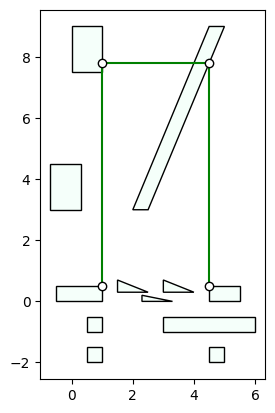

In [3]:
sol = G.solve_shortest_path()
plot_sol(sol)

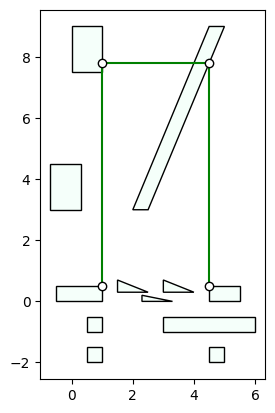

In [4]:
from large_gcs.algorithms.gcs_star import GcsStar
from large_gcs.algorithms.search_algorithm import AlgVisParams
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.domination_checkers.reaches_cheaper_sampling import (
    ReachesCheaperSampling,
)
from large_gcs.graph.cost_constraint_factory import l1_norm_shortcut_edge_cost_factory

cost_estimator = ShortcutEdgeCE(
    graph=G,
    shortcut_edge_cost_factory=l1_norm_shortcut_edge_cost_factory,
)
alg_vis_params = AlgVisParams()
domination_checker = ReachesCheaperSampling(graph=G, num_samples_per_vertex=10)
alg = GcsStar(
    graph=G,
    cost_estimator=cost_estimator,
    domination_checker=domination_checker,
    vis_params=alg_vis_params,
)
sol = alg.run()
plot_sol(sol)

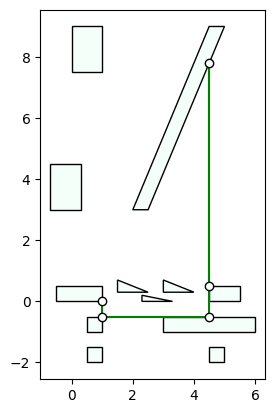

In [5]:
from large_gcs.domination_checkers.reaches_new_sampling import ReachesNewSampling


cost_estimator = ShortcutEdgeCE(
    graph=G,
    shortcut_edge_cost_factory=l1_norm_shortcut_edge_cost_factory,
)
alg_vis_params = AlgVisParams()
domination_checker = ReachesNewSampling(graph=G, num_samples_per_vertex=10)
alg = GcsStar(
    graph=G,
    cost_estimator=cost_estimator,
    domination_checker=domination_checker,
    vis_params=alg_vis_params,
)
sol = alg.run()
plot_sol(sol)

In [6]:
from large_gcs.algorithms.search_algorithm import AlgMetrics
from large_gcs.domination_checkers.reaches_cheaper_containment import ReachesCheaperContainment


domination_checker = ReachesCheaperContainment(graph=G)
domination_checker.set_alg_metrics(AlgMetrics())

candidate_node = SearchNode.from_vertex_path(["s", "p1", "p2"])
alt_node = SearchNode.from_vertex_path(["s", "p6", "p7", "p2"])
other_node = SearchNode.from_vertex_path(["s", "p8", "p9", "p2"])
cost_upper_bound = 20
add_upper_bound = True

cand_AH, _ = domination_checker._create_path_AH_polytope_from_full_sets(candidate_node, add_upper_bound=add_upper_bound, cost_upper_bound=cost_upper_bound)
alt_AH, _ = domination_checker._create_path_AH_polytope_from_full_sets(alt_node, add_upper_bound=add_upper_bound, cost_upper_bound=cost_upper_bound)
other_AH, _ = domination_checker._create_path_AH_polytope_from_full_sets(other_node, add_upper_bound=add_upper_bound, cost_upper_bound=cost_upper_bound)

domination_checker.is_contained_in(cand_AH, alt_AH)
# Should return False

False

In [7]:
domination_checker.is_contained_in(alt_AH, cand_AH)
# Should return False

False

In [8]:
domination_checker.is_contained_in(other_AH, cand_AH)
# Should return True

True

In [9]:
domination_checker.plot_containment(candidate_node, [other_node])

In [10]:
n_a = SearchNode.from_vertex_path(["s", "p0", "p2"])
n_b = SearchNode.from_vertex_path(["s", "p3", "p2"])
n_c = SearchNode.from_vertex_path(["s", "p4", "p2"])
n_d = SearchNode.from_vertex_path(["s", "p5", "p2"])
cost_upper_bound = 10

In [11]:
domination_checker.plot_containment(n_a, [n_b], cost_upper_bound=cost_upper_bound)
domination_checker.plot_containment(n_a, [n_c], cost_upper_bound=cost_upper_bound)
domination_checker.plot_containment(n_a, [n_d], cost_upper_bound=cost_upper_bound)

In [12]:
domination_checker.plot_containment(
    n_a, [n_b, n_c, n_d], cost_upper_bound=cost_upper_bound
)

In [13]:

# Should be False because even though as a union they dominate, individually they do not
print(
    "should be false: ",
    domination_checker.is_dominated(
        candidate_node=n_a, alternate_nodes=[n_b, n_c, n_d]
    ),
)
print(
    "should be false: ",
    domination_checker.is_dominated(candidate_node=n_a, alternate_nodes=[n_c]),
)


should be false:  False
should be false:  False
